In [1]:
import tensorflow as tf
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


> - User, Item에 대한 정보를 전혀 알수가 없다.

# Step 1. Data Preprocess
## 1.1 Data Load

> - ``SessionId`` : 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자
> - 이 데이터에서 UserID가 SessionID 역할을 해야 한다.

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [4]:
# UserId 컬럼명을 SessionId로 바꾸기
data.rename(columns={'UserId':'SessionId'}, inplace=True)
data

,SessionId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [17]:
# SessionId 개수 확인
print(f"unique number of sessions : {data['SessionId'].nunique()}")
print(f"unique number of items    : {data['ItemId'].nunique()}")

unique number of sessions : 6040
unique number of items    : 3706


## 1.2 Session Length
> - ``session_length`` : 해당 세션의 사용자가 그 세션 동안 몇개의 상품정보를 클릭했는지

In [5]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

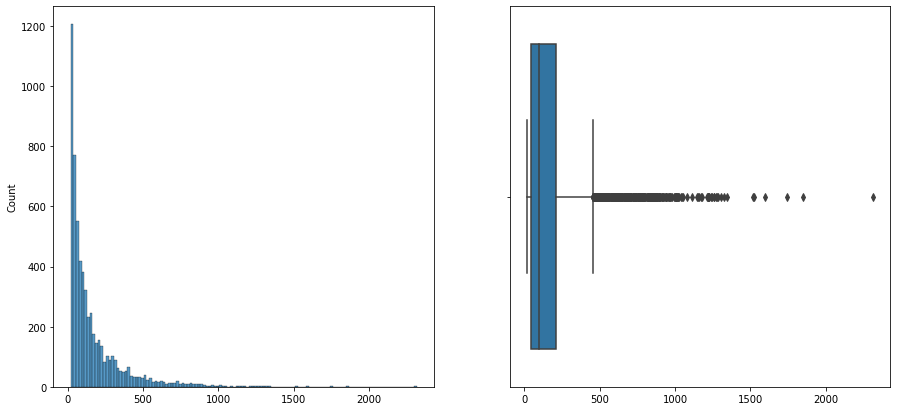

In [20]:
# 분포를 시각적으로 확인해보자
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,7))
plt.subplot(121)
sns.histplot(session_length)

plt.subplot(122)
sns.boxplot(session_length)
plt.show()

In [6]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:
session_length.min(), session_length.max()

(20, 2314)

In [8]:
session_length.quantile(0.999)

1343.181000000005

In [9]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [12]:
# IQR 로 이상치 탐지
# IQR = Q3 - Q1
Q1 = np.quantile(session_length, [0.25])
Q3 = np.quantile(session_length, [0.75])

IQR = Q3 - Q1
IQR = IQR * 1.5
lowest = Q1 - IQR
highest = Q3 + IQR

print(highest)

[454.]


> - 세션당 클릭 수는 평균 165개
> - 세션당 최소 클릭수 20개
> - 세션당 최대 클리수 2314개
> - 세션당 클릭 수 455개부터는 이상치로 봐도 될듯?

In [14]:
data.iloc[session_length[session_length == 454].index, :]

,SessionId,ItemId,Rating,Time
2644,22,1438,1,978136973


In [15]:
# SessionId 22의 클릭 아이템 및 시간 확인
data[data['SessionId'] == 22]

,SessionId,ItemId,Rating,Time
2582,22,1196,4,978134004
2695,22,1606,3,978134004
2780,22,1210,3,978134049
2840,22,2985,2,978134049
2783,22,1214,4,978134073
...,...,...,...,...
2809,22,3698,4,991149352
2709,22,1034,4,991149472
2623,22,3896,2,991149493
2646,22,908,4,991149661


In [22]:
# Time을 timestamp으로 알아볼 수 있게 표현해보자
print(f"세션 첫 클릭 시간 : {pd.to_datetime(data[data['SessionId'] == 22]['Time'].iloc[0], unit='s', origin='unix')}")
print(f"세션 끝 클릭 시간 : {pd.to_datetime(data[data['SessionId'] == 22]['Time'].iloc[-1], unit='s', origin='unix')}")

세션 첫 클릭 시간 : 2000-12-29 23:53:24
세션 끝 클릭 시간 : 2001-05-29 15:24:52


> - 한 세션이 반년동안 진행된다고..?
> - 포함할지 말지 고민해보자


20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64


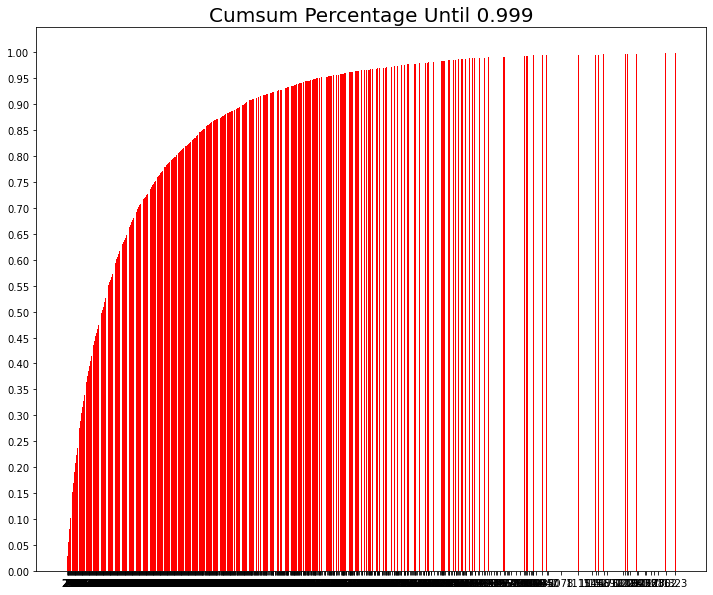

In [23]:
# session_length 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

print(length_percent_cumsum_999)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

> 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까?
> - User * Item Matrix의 빈칸이 너무 많아서 **(data sparsity)** 모델이 제대로 학습되지 않을 가능성이 있다. 

## 1.3 SessionTime
**추천 시스템에서 다룰 수 있는 시간 관련 데이터의 예**
- 생성 날짜, 접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등
- 현재 Time int 타입으로 Timestamp 으로 바꿔주자

In [28]:
data['Timestamp'] = data['Time'].map(lambda x: pd.to_datetime(x, unit='s', origin='unix'))

In [29]:
data

,SessionId,ItemId,Rating,Time,Timestamp
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [30]:
oldest, latest = data['Timestamp'].min(), data['Timestamp'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


> - 6개월치 데이터 중 1달 치 데이터만 사용해보자

In [25]:
type(latest)

numpy.int64

> - Timestamp 객체는 int 객체와 사칙연산 불가능
> - 날짜끼리의 차이 구하려면 datetime 라이브러리의 timedelta 객체 사용하자

In [33]:
two_month = latest - dt.timedelta(60)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
two_month
data = data[data['Timestamp'] > two_month]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,ItemId,Rating,Time,Timestamp
8704,59,2997,4,1041962568,2003-01-07 18:02:48
8721,59,2147,2,1041962639,2003-01-07 18:03:59
8781,59,2369,4,1041962664,2003-01-07 18:04:24
8797,59,3408,4,1041962692,2003-01-07 18:04:52
8808,59,2712,3,1041962692,2003-01-07 18:04:52
...,...,...,...,...,...
984731,5950,3948,4,1046369637,2003-02-27 18:13:57
984682,5950,3578,4,1046369670,2003-02-27 18:14:30
984475,5950,3793,3,1046369710,2003-02-27 18:15:10
984660,5950,3555,2,1046369737,2003-02-27 18:15:37


## 1.4 Data Cleansing
> - 유저가 최소 1개 이상 클릭 했을 때, 다음 클릭 예측하는게 목적이므로 길이 1인 세션 제거하기
> - 너무 적게 클릭된 아이템도 제거하기

In [34]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [35]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,ItemId,Rating,Time,Timestamp
8704,59,2997,4,1041962568,2003-01-07 18:02:48
8797,59,3408,4,1041962692,2003-01-07 18:04:52
8808,59,2712,3,1041962692,2003-01-07 18:04:52
8798,59,2396,4,1041962835,2003-01-07 18:07:15
8839,59,2762,3,1041962835,2003-01-07 18:07:15
...,...,...,...,...,...
984731,5950,3948,4,1046369637,2003-02-27 18:13:57
984682,5950,3578,4,1046369670,2003-02-27 18:14:30
984475,5950,3793,3,1046369710,2003-02-27 18:15:10
984660,5950,3555,2,1046369737,2003-02-27 18:15:37


In [36]:
# 제거됐는지 확인
data.groupby('SessionId').size()

SessionId
59      24
102      4
146      2
195      3
343      2
        ..
5657    19
5733     2
5878    41
5948     3
5950    15
Length: 82, dtype: int64

# 회고
---
- 추천시스템 너무 어렵다,,데이터 전처리 밖에 손을 못 대겠다.
- 앞에 추천시스템 Fundamental을 제대로 공부 못해서 이해하는데 더 어려움이 있는거 같다.
- 공부를 더 해서 제대로 마무리 하자.

## 1.5 Train / Valid / Test split


In [37]:
# train data set
print(oldest) ;print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [38]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

IndexError: list index out of range

> Test 셋과 Train 셋의 기간이 겹치는데?
> - 사용자 소비 패턴 변화에 따라 모델의 성능이 안좋아질수 있기때문에, **지금**을 잘 예측하는게 중요하다.

이번 실습에선 
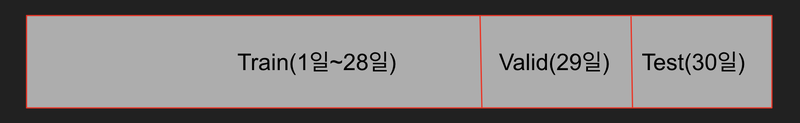
로 나눠보자.

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [ ]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [ ]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [ ]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

In [ ]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [ ]:
# 데이터 저장하기
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. 논문소개(GRU4REC)
### Recommendations with RNNs
[SESSION-BASED RECOMMENDATIONS WITH
RECURRENT NEURAL NETWORKS](https://arxiv.org/pdf/1511.06939v4.pdf)

- 2016년 ICLR에 공개된 논문
- Session data에 처음으로 RNN 계열 모델 적용하여 발표

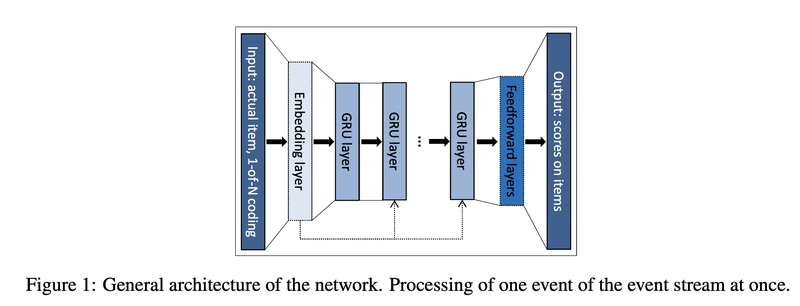
> - 이 논문의 저자는 GRU 모델의 성능이 제일 좋았다고 함.
> - 그리고 **Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다**고 함.
> - 이번 실습에서도 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용할 것.
> - Input : Actual state of the session
> - state of the session의 의미 : 1. Item of the actual event, one-hot vecotr, 2. Events in the session, weighted sum of these presentations
> - 이벤트 :  세션 안에 기본 단위, 주로 클릭
> - 이벤트 One-hot Encoding해서 GRU에 input으로 넣기 -> Output은 다음에 나올 이벤트 확률(아이템의 score)

#### 기존 RNN batch 방식 적용 못하는 이유?
> 1. Session 길이가 매우 다르다.
> 2. 시간 변화에 따라 session이 어떻게 생격나는지 학습하는 것이 목적이다.

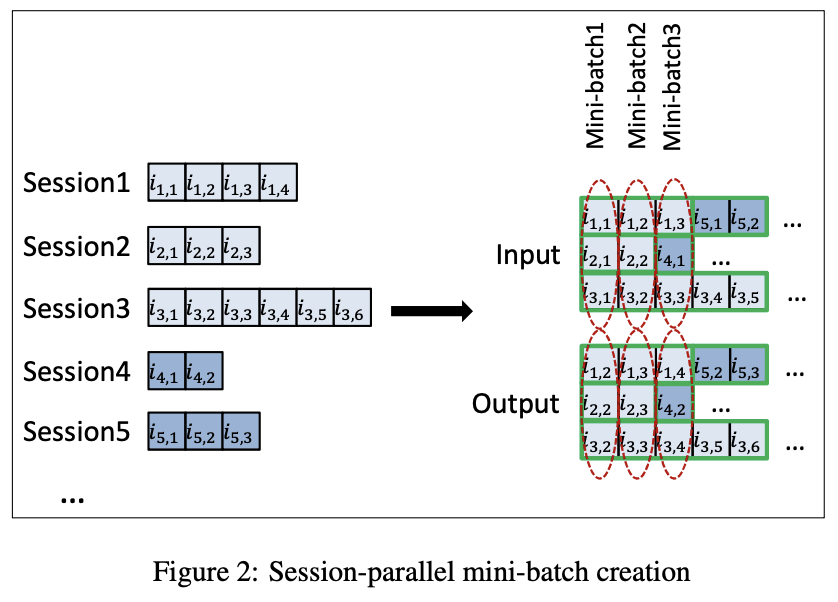

*Session은 모두 독립이며, hidden state를 reset한다.*
>1. 각 Session들을 정렬시킨다
>2. 그 다음 mini-batch의 형태를 구성하기 위해서 개의 session에서 첫 event만을 사용한다.
>3. 그 다음 event들로 mini-batch를 구성한다.

< 참고 사이트 >
- https://velog.io/@suminwooo/%EC%B6%94%EC%B2%9C-%EC%8B%9C%EC%8A%A4%ED%85%9C21
- https://www.comworld.co.kr/news/articleView.html?idxno=50160

# 3. Data Pipeline
- Session-Parallel Mini-Batch 구현해보자

## 3.1 SessionDataset

In [ ]:
# click_offsets 변수 - 각 세션이 시작된 인덱스를 담고 있음
# session_idx 변수 - 각 세션을 인덱싱한 np.array
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets 

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

In [ ]:
tr_dataset.click_offsets

In [ ]:
tr_dataset.session_idx

## 3.2 SessionDataLoader

In [ ]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [ ]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

In [ ]:
iter_ex = iter(tr_data_loader)

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

# 4. Modeling
## 4.1 Evaluation Metric

In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 4.2 Model Architecture

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [ ]:
model = create_model(args)

## 4.3 Model Training

In [ ]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

## 5.4 Inference

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)